# A rotating mesh with spots

In [1]:
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_rotation, evaluate_rotation
from spice.models.spots import add_spot
from spice.plots import plot_3D, plot_3D_mesh_and_spectrum
from spice.spectrum import simulate_observed_flux
import astropy.units as u
import jax.numpy as jnp
import numpy as np
from transformer_payne import TransformerPayne
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from jax import config

In [2]:
tp = TransformerPayne.download()

line_center = 6173
vws = jnp.linspace(line_center-2., line_center+2., 1000)
res = tp.intensity(jnp.log10(vws), 1., tp.to_parameters(dict(logteff=jnp.log10(5000))))
res2 = tp.intensity(jnp.log10(vws), 1., tp.to_parameters(dict(logteff=jnp.log10(4500))))
res3 = tp.intensity(jnp.log10(vws), 1., tp.to_parameters(dict(logteff=jnp.log10(4000))))
res4 = tp.intensity(jnp.log10(vws), 1., tp.to_parameters(dict(logteff=jnp.log10(3500))))

/scratch/y89/mj8805/miniforge/envs/astro/lib/python3.12/site-packages/jax/_src/linear_util.py:370: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in logspace is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  ans = _fun(*args, **kwargs)
/scratch/y89/mj8805/miniforge/envs/astro/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/scratch/y89/mj8805/miniforge/envs/astro/lib/python3.12/site-packages/t

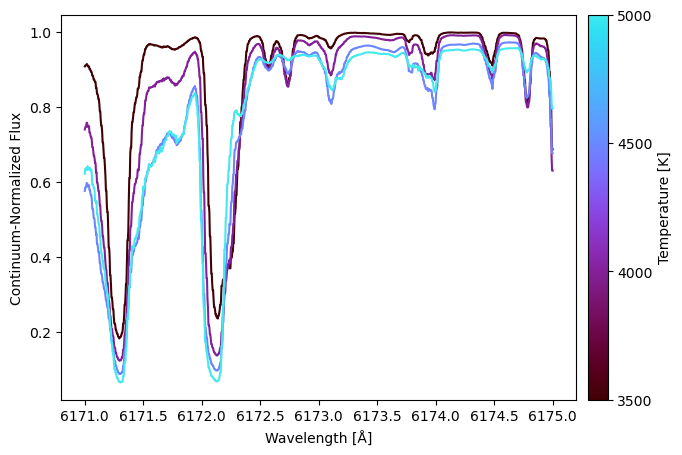

In [3]:
import cmasher as cmr
import matplotlib as mpl

temps = [5000, 4500, 4000, 3500]
ress = [res, res2, res3, res4]
fractions = [0.0, 0.33, 0.66, 1.0]

fig, ax = plt.subplots(figsize=(8,5))

for temp, r, f in zip(temps, ress, fractions):
    ax.plot(vws, r[:, 0]/r[:, 1], color=cmr.gem(f), label=f"{temp} K")

# Add colorbar for temperature
# Create a mappable object for the colorbar
norm = mpl.colors.Normalize(vmin=min(temps), vmax=max(temps))
sm = mpl.cm.ScalarMappable(cmap=cmr.gem, norm=norm)
sm.set_array([])  # not strictly needed for modern mpl

cbar = fig.colorbar(sm, ax=ax, label='Temperature [K]', pad=0.02)
cbar.set_ticks(temps)
cbar.set_ticklabels([str(t) for t in temps])

ax.set_xlabel("Wavelength [Å]")
ax.set_ylabel("Continuum-Normalized Flux")
plt.show()

Let's use the simplest example for the sake of speed - the blackbody flux from the ```transformer_payne``` package.

The API is in the functional paradigm - you pass a "model" mesh, and the function returns a modified version of the mesh. However, the original passed mesh still remains if you choose not to overwrite these variables.

This function will add two temperature spherical harmonics.

In [4]:
from spice.models.mesh_transform import add_pulsation


base_temp = 5500
spot_temp = 2000

m = IcosphereModel.construct(5000, 1., 1., tp.to_parameters(dict(logteff=jnp.log10(base_temp))), tp.stellar_parameter_names)

# Add temperature spots
m_spotted = add_rotation(add_spot(m, jnp.deg2rad(60), jnp.deg2rad(-30), 30, -jnp.log10(spot_temp), 0, 0.3), 8)

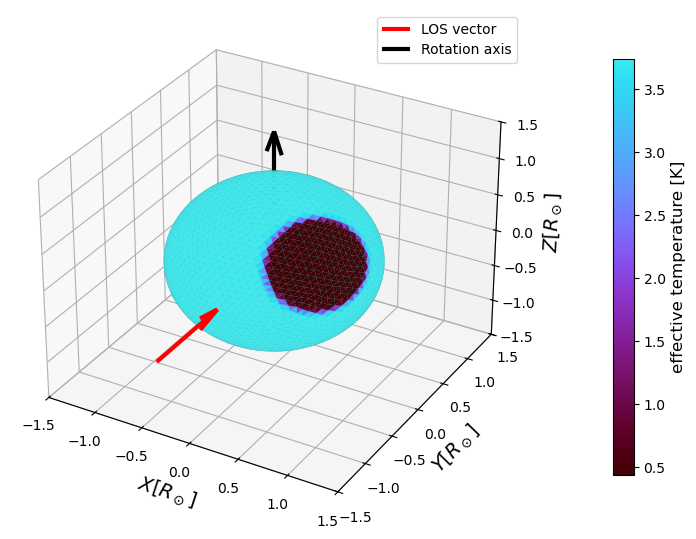

In [5]:
_, _ = plot_3D(m_spotted, 0, cmap='cmr.gem', property_label='effective temperature [K]')

## Spectrum emulation

In [6]:
# Calculate rotation period for 20 km/s at the stellar equator

# Assume: R_star in solar radii (1 R_sun = 6.957e10 cm), velocity in km/s

R_sun_cm = 6.957e10     # cm
R_star_Rsun = 1.0       # (from model construction above)
v_rot_kms = 8        # km/s

# Compute circumference at equator
circum_cm = 2 * jnp.pi * R_star_Rsun * R_sun_cm
v_rot_cms = v_rot_kms * 1e5

period_s = circum_cm / v_rot_cms    # seconds
period_days = period_s / 86400.

print(f"Rotation period for {v_rot_kms:.1f} km/s equatorial velocity: {period_days:.2f} days")

Rotation period for 8.0 km/s equatorial velocity: 6.32 days


In [7]:
times = jnp.linspace(0, period_s, 100)
mts = [evaluate_rotation(m_spotted, t) for t in times]

In [8]:
line_center = 6173
vws = jnp.linspace(line_center-2., line_center+2., 1000)
specs = [simulate_observed_flux(tp.intensity, mt0, jnp.log10(vws)) for mt0 in tqdm(mts)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:17<00:00,  4.38s/it]


In [9]:
specs = np.array(specs)

In [10]:
import matplotlib.pyplot as plt

/jobfs/154526212.gadi-pbs/ipykernel_179508/3049493653.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('cmr.gem')


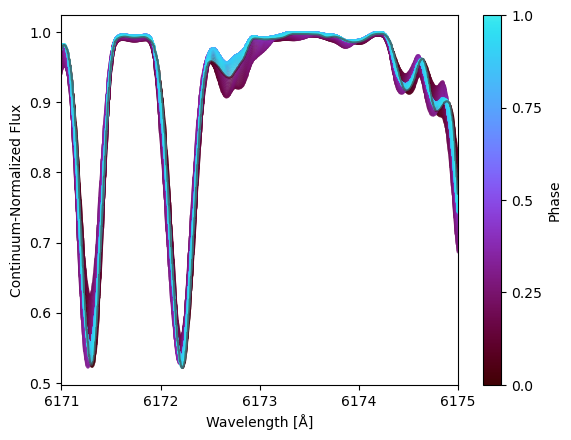

In [25]:
from matplotlib import cm

phases = (times % period_s) / period_s
cmap = cm.get_cmap('cmr.gem')
for s, phase in zip(specs, phases):
    plt.plot(vws, s[:, 0]/s[:, 1], color=cmap(phase), alpha=0.5)
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=plt.gca(), label='Phase')
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])
cbar.set_ticklabels(['0.0', '0.25', '0.5', '0.75', '1.0'])
plt.gca().set_ylabel('Continuum-Normalized Flux')
plt.gca().set_xlabel('Wavelength [Å]')
plt.gca().set_xticks(np.linspace(vws[0], vws[-1], 5))
plt.gca().set_xlim(vws[0], vws[-1])
plt.show()

In [12]:
from spice.plots.plot_mesh import animate_mesh_and_spectra


animate_mesh_and_spectra(mts, specs[:, :, 0]/specs[:, :, 1], vws, property=0,
                         property_label='effective temperature [K]', filename='spots.gif')

'spots.gif'

## Photometric time series

In [13]:
from spice.spectrum.filter import GaiaG, GaiaBP, GaiaRP
from spice.spectrum.spectrum import AB_passband_luminosity

In [14]:
gaia_g = GaiaG()
gaia_bp = GaiaBP()
gaia_rp = GaiaRP()

In [15]:
d = u.AU.to(u.cm)
g_phot = np.array([AB_passband_luminosity(gaia_g, vws, flux[:, 0]) for flux in specs])
bp_phot = np.array([AB_passband_luminosity(gaia_bp, vws, flux[:, 0]) for flux in specs])
rp_phot = np.array([AB_passband_luminosity(gaia_rp, vws, flux[:, 0]) for flux in specs])

BP_RP = bp_phot - rp_phot

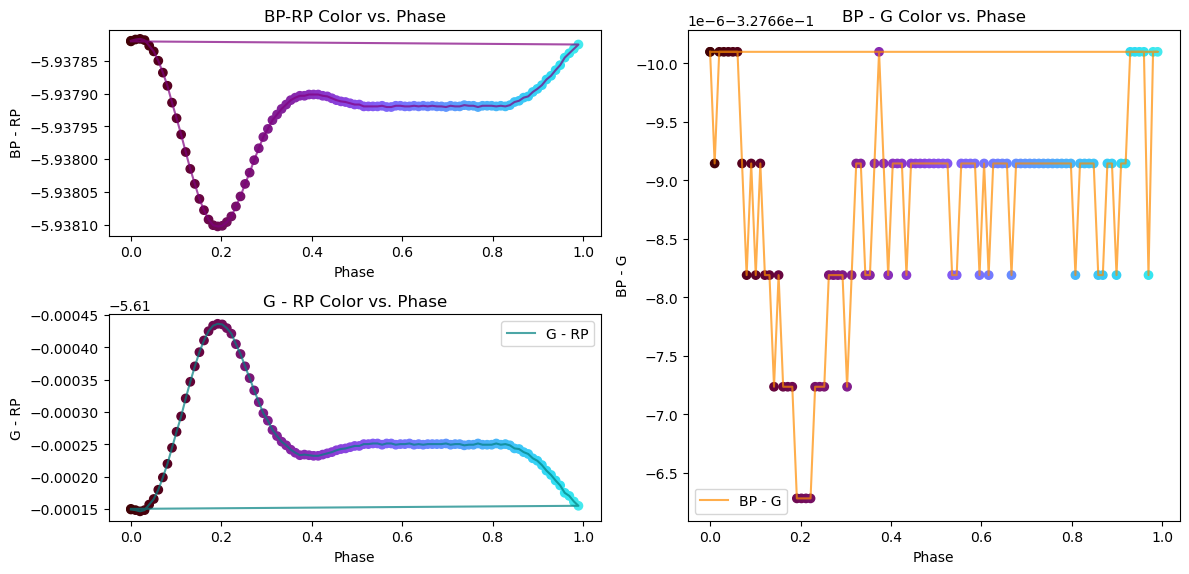

In [16]:
import matplotlib.gridspec as gridspec

# Compute phase from times
# Assume period is a known value; for demonstration, we use variable 'period'
# You may need to set 'period' before this cell if not already defined
phase = (times % period_s) / period_s

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 2, figure=fig)

# BP-RP color variation diagram
ax_bp_rp = fig.add_subplot(gs[0, 0])
ax_bp_rp.plot(phase, BP_RP, color='purple', alpha=0.7)
ax_bp_rp.scatter(phase, BP_RP, c=phase, cmap='cmr.gem')
ax_bp_rp.set_xlabel('Phase')
ax_bp_rp.set_ylabel('BP - RP')
ax_bp_rp.set_title('BP-RP Color vs. Phase')

# Color lightcurve 1: G - RP
g_rp = g_phot - rp_phot
ax_g_rp = fig.add_subplot(gs[1, 0])
ax_g_rp.plot(phase, g_rp, color='teal', label='G - RP', alpha=0.7)
ax_g_rp.scatter(phase, g_rp, c=phase, cmap='cmr.gem')
ax_g_rp.set_xlabel('Phase')
ax_g_rp.set_ylabel('G - RP')
ax_g_rp.set_title('G - RP Color vs. Phase')
ax_g_rp.legend()
ax_g_rp.invert_yaxis()

# Color lightcurve 2: BP - G
bp_g = bp_phot - g_phot
ax_bp_g = fig.add_subplot(gs[:, 1])
ax_bp_g.plot(phase, bp_g, color='darkorange', label='BP - G', alpha=0.7)
ax_bp_g.scatter(phase, bp_g, c=phase, cmap='cmr.gem')
ax_bp_g.set_xlabel('Phase')
ax_bp_g.set_ylabel('BP - G')
ax_bp_g.set_title('BP - G Color vs. Phase')
ax_bp_g.legend()
ax_bp_g.invert_yaxis()

plt.tight_layout()